<a href="https://colab.research.google.com/github/entc-17-fyp-20/CM_Normal_Behaviour_Modeling/blob/akeshala/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and datasets

In [1]:
# multivariate data preparation
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, Dropout, LocallyConnected2D, LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
#@title Select Dataset New { display-mode: "form" }
turbine = 'T01' #@param ["T01", "T02","T03","T22","T34","T54"]
path = '/content/drive/MyDrive/IIoT - Wind Turbine/FYP/Dataset/Merged/' + turbine + '.csv'
df = pd.read_csv(path)

In [4]:
n_steps = 144

In [5]:
#@title Select scaling method { display-mode: "form" }
method = 'MinMax' #@param ["Normalize", "MinMax"]

df_time = df["Date_Time"]
df.drop("Date_Time", axis='columns', inplace=True)
column_names = df.columns

if method == "Normalize":
  d = preprocessing.normalize(df, axis=0)
else:
  scaler = preprocessing.MinMaxScaler()
  d = scaler.fit_transform(df)

df = pd.DataFrame(d, columns=column_names)
df["Date_Time"] = df_time
df = df.set_index(df['Date_Time'])

In [6]:
n_features = 4

format = '%Y-%m-%d %H:%M:%S'
split_index=[];
split_index.append(df['Date_Time'][0])
for i in range(0,len(df['Date_Time'])-1):
  current_time =  df['Date_Time'][i]
  following_time=  df['Date_Time'][i+1]
  time_gap =datetime.strptime(following_time, format)-datetime.strptime(current_time, format)
  if (time_gap.total_seconds() != 600):
    split_index.append(current_time)
    split_index.append(following_time)
split_index.append(df['Date_Time'][len(df['Date_Time'])-1])

df = df.set_index(df['Date_Time'])

In [ ]:
# print(len(split_index))
# print(len(split_index)*0.57)


In [36]:
# i = 128

In [ ]:
# df[split_index[i]:split_index[i+1]]

In [7]:
X_concat_train, y_concat_train, y_concat_test, X_concat_test = [],[],[],[]

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]
  if len(dfx)>=144:
    dfx = dfx[['Active_Power','Ambient_Temperature','Wind_Speed','Generator_RPM','Gear_Oil_Tempeature']]
    dfx = dfx.to_numpy()
    # convert into input/output
    X, y = split_sequences(dfx, n_steps)
    if i<len(split_index)*0.3:
      X_concat_train.append(X)
      y_concat_train.append(y)
    elif i<len(split_index)*0.5:
      X_concat_test.append(X)
      y_concat_test.append(y)

X_concat_train = tuple(X_concat_train)
y_concat_train = tuple(y_concat_train)

X_concat_test = tuple(X_concat_test)
y_concat_test = tuple(y_concat_test)

In [8]:
X_train = np.concatenate(X_concat_train)
y_train = np.concatenate(y_concat_train)

X_test = np.concatenate(X_concat_test)
y_test = np.concatenate(y_concat_test)

In [9]:
print("Train "+str(len(X_train)))
print("Test "+str(len(X_test)))
print(X_train.shape)
print(y_train.shape)

Train 40059
Test 409
(40059, 144, 4)
(40059,)


# Model

In [10]:
def create_model():
# define model
  model1 = Sequential()
  model1.add(Conv2D(filters=128, kernel_size=(32,4), padding="same", activation='relu', input_shape=(n_steps, n_features,1)))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv2D(filters=128, kernel_size=(18,4), padding="same", activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv2D(filters=128, kernel_size=(8,4), padding="same", activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv2D(filters=128, kernel_size=(8,4), padding="same", activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(LocallyConnected2D(filters=10, kernel_size=(8, 4), activation="relu"))
  model1.add(Flatten())
  model1.add(Dense(20, activation='relu'))
  model1.add(Dense(1))
  model1.add(LeakyReLU(alpha=0.1))
  model1.compile(optimizer='adam', loss='mse')
  return model1

# Training 

In [11]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))

In [13]:
n_features = X_train.shape[2]

model = create_model()

# fit model
history = model.fit(X_train, y_train, batch_size=5, validation_data=(X_test,y_test), callbacks=[earlystop, best_val], epochs=10, verbose=1)

Epoch 1/10
8012/8012 [==============================] - 494s 57ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 2/10
8012/8012 [==============================] - 459s 57ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/10
8012/8012 [==============================] - 458s 57ms/step - loss: 0.0026 - val_loss: 6.0820e-04
Epoch 4/10
8012/8012 [==============================] - 458s 57ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/10
8012/8012 [==============================] - 469s 59ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/10
8012/8012 [==============================] - 472s 59ms/step - loss: 0.0016 - val_loss: 6.7676e-04


In [14]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

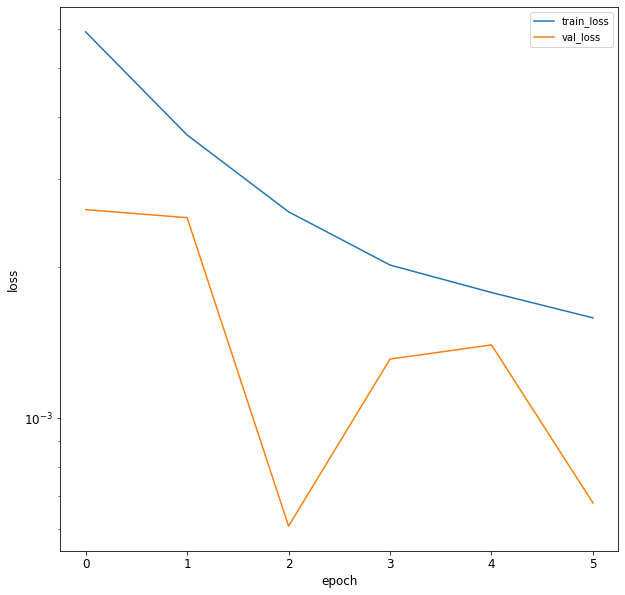

In [15]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [16]:
# Save the weights
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN2/'
model.save_weights(path)

# Import pre-trained weights

In [17]:
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN2.1/'
# Create a new model instance
model = create_model()
# Restore the weights
model.load_weights(path)

# Testing on the same turbine

In [18]:
# demonstrate prediction
yhat = model.predict(X_test, verbose=0)

In [19]:
yhat = yhat.reshape(yhat.shape[0],)
df_final=pd.DataFrame({'y_hat':yhat,'y_test':y_test})

In [20]:
df_final['difference'] = df_final['y_hat']-df_final['y_test']
df_final["abs_difference"] = abs(df_final['y_hat']-df_final['y_test'])
print(df_final["difference"].mean())
print(df_final["abs_difference"].mean())

-0.008514402472302509
0.01984441614967104


In [21]:
df_final.to_csv('drive/MyDrive/DatasetsWind/df_final.csv', index=False)

# Results, Plots

In [22]:
# Adding data_time column back
frames = []

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]

  if i>=len(split_index)*0.8:
    frames.append(dfx.iloc[n_steps-1:,:])

test = pd.concat(frames)
test.drop("Date_Time", axis='columns', inplace=True)
test = test.reset_index()
df_final["Date_Time"] = test["Date_Time"]

In [23]:
column_name = 'y_test' 
column_name1 = 'y_hat'

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=df_final['Date_Time'],y=df_final[column_name1], mode='lines', name='Predicted'))
fig.update_layout(title_text= "Actual vs Predicted")

fig.show()

In [24]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [25]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()

Re-sampling data

In [26]:
#@title Resampling { display-mode: "form" }
sample_frequency = 60 #@param {type:"slider", min:20, max:120, step:10}
sample = str(sample_frequency) + "min"

In [27]:
df_final['Date_Time'] = pd.to_datetime(df_final['Date_Time'], format="%Y-%m-%d %H:%M:%S")
df_final.set_index('Date_Time', inplace = True)
df_resample = df_final.resample(sample).mean().reset_index()
df_final = df_final.reset_index()

In [28]:
df_final

,Date_Time,y_hat,y_test,difference,abs_difference
0,2018-12-21 10:30:00,0.641028,0.60,0.041028,0.041028
1,2018-12-21 10:40:00,0.633135,0.60,0.033135,0.033135
2,2018-12-21 10:50:00,0.634407,0.62,0.014407,0.014407
3,2018-12-21 11:00:00,0.640025,0.62,0.020025,0.020025
4,2018-12-21 11:10:00,0.651867,0.64,0.011867,0.011867
...,...,...,...,...,...
404,2018-12-24 05:50:00,0.654180,0.66,-0.005820,0.005820
405,2018-12-24 06:00:00,0.674133,0.68,-0.005867,0.005867
406,2018-12-24 06:10:00,0.687857,0.70,-0.012143,0.012143
407,2018-12-24 06:20:00,0.682694,0.70,-0.017306,0.017306


In [29]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [30]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()